In [3]:
from model import run_inference, draw_prediction_on_image, movenet, init_crop_region, determine_crop_region, to_gif
import tensorflow as tf
import numpy as np 
from typing import Tuple


In [4]:
INPUT_SIZE = 192
def create_outlined_video(video: np.ndarray, video_config: dict) -> Tuple[list, list]:
    '''
    Creates an outlined video from the input video
    '''

    output_images = []
    keypoints = []
    #bar = display(progress(0, num_frames-1), display_id=True)
    #unpacked the config
    num_frames, image_height, image_width, crop_region = video_config['num_frames'], video_config['image_height'], video_config['image_width'], video_config['crop_region']
    num_frames = 2
    for frame_idx in range(num_frames):
        print(frame_idx)
        keypoints_with_scores = run_inference(
            movenet, video[frame_idx, :, :, :], crop_region,
            crop_size=[INPUT_SIZE, INPUT_SIZE])
        keypoints.append(keypoints_with_scores)
        output_images.append(draw_prediction_on_image(
            video[frame_idx, :, :, :].numpy().astype(np.int32),
            keypoints_with_scores, crop_region=None,
            close_figure=True, output_image_height=300))
        crop_region = determine_crop_region(
            keypoints_with_scores, image_height, image_width)
    output = np.stack(output_images, axis=0)

    return output, keypoints
    #bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.

def get_video(path: str) -> np.ndarray:
    '''
    Gets the video from the path
    '''
    video = tf.io.read_file(path)
    video = tf.image.decode_gif(video)
    return video

#create a parameter config for the vidoe containing num_frames, image_height, image_width and crop region
def create_config(video: np.ndarray) -> dict:
    '''
    Creates a config for the video
    '''
    num_frames, image_height, image_width, _ = video.shape
    crop_region = init_crop_region(image_height, image_width)
    return {
        'num_frames': num_frames,
        'image_height': image_height,
        'image_width': image_width,
        'crop_region': crop_region
    }

# Load the input image.

In [5]:
# Load the input image.
video_path_instructor = 'mm1.gif'
video = get_video(video_path_instructor)
video_config = create_config(video)


output_instructor, keypoints_instructor = create_outlined_video(video, video_config)
a = to_gif(output_instructor, fps=10, filename='output/instructor_mm1.gif')

2022-10-10 21:53:32.151338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0
1
Gif saved to ./output/instructor_mm1.gif


In [7]:
from grader import create_slope_matrices
slopes_instructor = create_slope_matrices(keypoints_instructor)
slopes_instructor.shape
slopes_student = slopes_instructor+1


x
x
done stacking


In [61]:
from math import degrees, atan

def angle(s1, s2): 
    return degrees(atan((s2-s1)/(1+(s2*s1))))

def get_delta_slope(matrix1, matrix2):
    delta = matrix1 - matrix2
    return abs(delta[np.triu_indices_from(delta, k=1)].mean())
def get_grade_angles(matrix):
    return abs(matrix[np.triu_indices_from(matrix, k=1)].mean())
def calculate_angles(slopes1, slopes2):
    angles = np.zeros((17,17))
    for i in range(17):
        for j in range(i+1,17):
            angles[i,j] = abs(angle(slopes1[i,j], slopes2[i,j]))
    return angles

In [67]:
slope_grades = [get_delta_slope(slopes_instructor[i], slopes_student[i]) for i in range(2)]
angles = [calculate_angles(slopes_instructor[i], slopes_student[i]) for i in range(2)]
angle_grades = [np.round(get_grade_angles(angle_matrix),2) for angle_matrix in angles]

Gif saved to ./output/red.gif



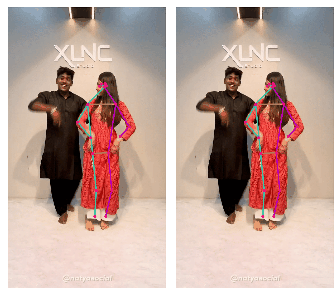

In [106]:
res = np.dstack((output_instructor,output_instructor))
res.shape
to_gif(res, fps=10, filename='output/red.gif')

In [139]:
from PIL import Image, ImageDraw, ImageSequence,ImageFont
from matplotlib import font_manager
import random
import io

im = Image.open('output/d1.gif')

font = font_manager.FontProperties(family='sans-serif', weight='heavy', size='large')
file = font_manager.findfont(font)
font = ImageFont.truetype(file, 48)

frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    d.text((100,10), str(random.randint(0,100)), font=font)
    del d

    # However, 'frame' is still the animated image with many frames
    # It has simply been seeked to a later frame
    # For our list of frames, we only want the current frame

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
frames[0].save('out.gif', save_all=True, append_images=frames[1:])
print('with text')

with text


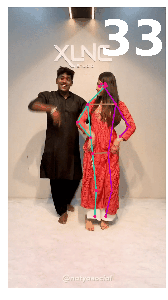

In [140]:
frames[0]